# ORF recognition by Convolutional/Recurrent
Attempting to train the model on simulated RNA sequences of length 256.



In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-07-20 19:28:08 UTC'

In [2]:
#Input
PC_SEQUENCES=64000   # how many protein-coding sequences
NC_SEQUENCES=64000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=256            # how long is each sequence
CDS_LEN=128            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs

#Model
FILTERS = 32   # how many different patterns the model looks for
CELLS = 256 #Used in LSTM layer(s)
NEURONS = 512 #Used in Dense layer(s)
DROP_RATE = 0.2
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
ACTIVATION = 'relu'

#Training
EPOCHS=50  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=1  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
#pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 361329 trials to reach 65000 per class.
Use 65000 PC seqs
Use 65000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 256.0
Average ORF length: 156.45143076923077
NC seqs
Average RNA length: 256.0
Average ORF length: 67.35706153846154


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()

    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())

    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())

    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))

    dnn.add(Dense(NEURONS,activation=ACTIVATION,dtype=np.float32))

    dnn.add(Dropout(DROP_RATE))

    dnn.add(Dense(1,activation=ACTIVATION,dtype=np.float32))

    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss

    dnn.build() 

    return dnn

model = make_DNN()
print(model.summary())

make_DNN
input shape: (256, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 32)           416       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 32)           3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
lstm (LSTM)              

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (256, 4)
FIT
Epoch 1/50
2667/2667 [==============================] - 61s 15ms/step - loss: 0.7060 - accuracy: 0.5118 - val_loss: 0.6937 - val_accuracy: 0.5019


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
2667/2667 [==============================] - 38s 14ms/step - loss: 0.6954 - accuracy: 0.5135 - val_loss: 0.6972 - val_accuracy: 0.4994
Epoch 3/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6942 - accuracy: 0.5174 - val_loss: 0.6549 - val_accuracy: 0.6230


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.6421 - accuracy: 0.6307 - val_loss: 0.6109 - val_accuracy: 0.6633


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.6164 - accuracy: 0.6601 - val_loss: 0.5973 - val_accuracy: 0.6796


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6017 - accuracy: 0.6757 - val_loss: 0.6035 - val_accuracy: 0.6717
Epoch 7/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5977 - accuracy: 0.6808 - val_loss: 0.6098 - val_accuracy: 0.6733
Epoch 8/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5948 - accuracy: 0.6797 - val_loss: 0.5914 - val_accuracy: 0.6842


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.6139 - accuracy: 0.6498 - val_loss: 0.5924 - val_accuracy: 0.6795
Epoch 10/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5910 - accuracy: 0.6847 - val_loss: 0.5854 - val_accuracy: 0.6876


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/50
2667/2667 [==============================] - 42s 16ms/step - loss: 0.5896 - accuracy: 0.6868 - val_loss: 0.5896 - val_accuracy: 0.6842
Epoch 12/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5822 - accuracy: 0.6947 - val_loss: 0.5816 - val_accuracy: 0.6917


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 13/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.6316 - accuracy: 0.6367 - val_loss: 0.6380 - val_accuracy: 0.6827
Epoch 14/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5975 - accuracy: 0.6831 - val_loss: 0.5904 - val_accuracy: 0.6837
Epoch 15/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5801 - accuracy: 0.6959 - val_loss: 0.6791 - val_accuracy: 0.5673
Epoch 16/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5933 - accuracy: 0.6817 - val_loss: 0.5745 - val_accuracy: 0.6977


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5756 - accuracy: 0.7018 - val_loss: 0.5725 - val_accuracy: 0.6985


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/50
2667/2667 [==============================] - 42s 16ms/step - loss: 0.5684 - accuracy: 0.7051 - val_loss: 0.7346 - val_accuracy: 0.5006
Epoch 19/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5994 - accuracy: 0.6751 - val_loss: 0.5917 - val_accuracy: 0.6859
Epoch 20/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5626 - accuracy: 0.7137 - val_loss: 0.5866 - val_accuracy: 0.7025


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5587 - accuracy: 0.7155 - val_loss: 0.6640 - val_accuracy: 0.5971
Epoch 22/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5677 - accuracy: 0.7077 - val_loss: 0.5057 - val_accuracy: 0.7583


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5023 - accuracy: 0.7606 - val_loss: 0.6034 - val_accuracy: 0.6745
Epoch 24/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5603 - accuracy: 0.7146 - val_loss: 0.5790 - val_accuracy: 0.7030
Epoch 25/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5958 - accuracy: 0.6814 - val_loss: 0.6386 - val_accuracy: 0.6348
Epoch 26/50
2667/2667 [==============================] - 42s 16ms/step - loss: 0.6220 - accuracy: 0.6520 - val_loss: 0.6754 - val_accuracy: 0.5794
Epoch 27/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.6429 - accuracy: 0.6232 - val_loss: 0.5313 - val_accuracy: 0.7367
Epoch 28/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6375 - accuracy: 0.6085 - val_loss: 0.6644 - val_accuracy: 0.5936
Epoch 29/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6531 - accuracy: 0.6171 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.6372 - accuracy: 0.6135 - val_loss: 0.5791 - val_accuracy: 0.7064
Epoch 44/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5551 - accuracy: 0.7332 - val_loss: 0.5201 - val_accuracy: 0.7501
Epoch 45/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5374 - accuracy: 0.7511 - val_loss: 0.5715 - val_accuracy: 0.7252
Epoch 46/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5202 - accuracy: 0.7718 - val_loss: 0.4868 - val_accuracy: 0.7813
Epoch 47/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.4976 - accuracy: 0.7827 - val_loss: 0.4255 - val_accuracy: 0.8396


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 48/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.4510 - accuracy: 0.8203 - val_loss: 0.4704 - val_accuracy: 0.7918
Epoch 49/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.4837 - accuracy: 0.7984 - val_loss: 0.5652 - val_accuracy: 0.7159
Epoch 50/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.6010 - accuracy: 0.6807 - val_loss: 0.6424 - val_accuracy: 0.6348
Fold 1, 50 epochs, 2151 sec


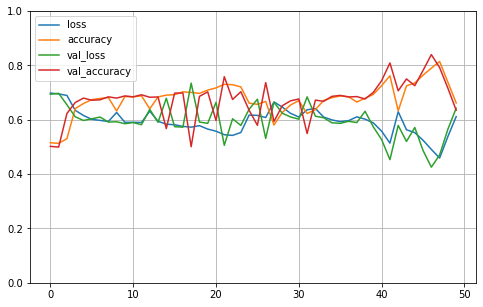

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 85.70%


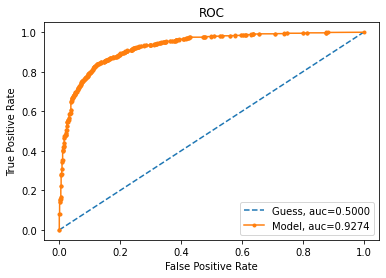

AUC: 92.74%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-07-20 20:05:11 UTC'